In [1]:
import sys

import dgl
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

Using backend: pytorch


In [2]:
from cbbstats.data import columns
from cbbstats.data.graph_dataset import GraphDataset

In [3]:
train_df = pd.read_json('data/2011-2020_boxscores.json.gz')
val_df = pd.read_json('data/2021-2021_boxscores.json.gz')

In [7]:
train_df['y'] = train_df['PTS'] - train_df['OPP_PTS']

In [21]:
def home_away(value):
    if value == 'H':
        return [1, 0]
    elif value == 'A':
        return [0, 0]
    else:
        return [0, 1]

In [28]:
np.vstack(train_df['HOME_AWAY'].apply(home_away).values)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 0],
       [1, 0],
       [0, 0]])

In [13]:
train_ds = GraphDataset(train_df)
val_ds = GraphDataset(val_df)

train_dataloader = dgl.dataloading.GraphDataLoader(train_ds, batch_size=1)
val_dataloader = dgl.dataloading.GraphDataLoader(val_ds, batch_size=1)

In [14]:
graph = train_ds[0][0]

In [19]:
graph.in_degrees().shape, graph.number_of_nodes()

(torch.Size([355]), 355)

In [5]:
h_graph, p_graph = train_ds[0]

In [6]:
h_graph, p_graph

(Graph(num_nodes=355, num_edges=720,
       ndata_schemes={}
       edata_schemes={'feat': Scheme(shape=(49,), dtype=torch.float32), 'y': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=355, num_edges=128,
       ndata_schemes={}
       edata_schemes={'y': Scheme(shape=(1,), dtype=torch.float32)}))

In [7]:
h_graph.update_all(
    message_func=dgl.function.copy_e('y', 'sum_y'),
    reduce_func=dgl.function.mean('sum_y', 'avg_y')
)

In [8]:
p_graph.ndata['avg_y'] = h_graph.ndata['avg_y']

In [9]:
p_graph.apply_edges(dgl.function.u_sub_v('avg_y', 'avg_y', 'naive_y'))

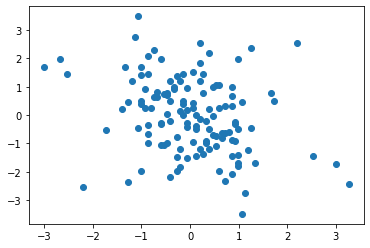

In [10]:
targets = p_graph.edata['y'].numpy().reshape(-1)
preds = p_graph.edata['naive_y'].numpy().reshape(-1)
plt.scatter(targets, preds)
plt.show()

In [11]:
class Model(torch.nn.Module):
    def __init__(self, in_feat, hidden_feat):
        super().__init__()
        self.linear = torch.nn.Linear(in_feat, hidden_feat)
        self.sage1 = dgl.nn.SAGEConv(hidden_feat, hidden_feat, 'mean')
        self.sage2 = dgl.nn.SAGEConv(hidden_feat, hidden_feat, 'mean')
        self.W1 = torch.nn.Linear(hidden_feat * 2, hidden_feat)
        self.W2 = torch.nn.Linear(hidden_feat, 1)
    
    def edge_to_node(self, graph, efeat):
        with graph.local_scope():
            graph.edata['h'] = efeat
            graph.update_all(
                message_func=dgl.function.copy_e('h', 'e'),
                reduce_func=dgl.function.mean('e', 'h')
            )
            return torch.nn.functional.relu(self.linear(graph.ndata['h']))
    
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(torch.nn.functional.relu(self.W1(h)))}

    def pred(self, graph, nfeat):
        with graph.local_scope():
            graph.ndata['h'] = nfeat
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']
    
    def forward(self, graph, efeat, pgraph):
        x = self.edge_to_node(graph, efeat)
        x = torch.nn.functional.relu(self.sage1(graph, x))
        x = torch.nn.functional.relu(self.sage2(graph, x))
        p = self.pred(pgraph, x)
        return p

In [12]:
model = Model(49, 300)

In [13]:
loss_fn = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm.tqdm(train_dataloader, file=sys.stdout)
    epoch_loss = 0
    epoch_samples = 0
    for hgraph, pgraph in tqdm_loader:
        preds = model(hgraph, hgraph.edata['feat'], pgraph)
        loss = loss_fn(pgraph.edata['y'], preds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_samples += 1
        tqdm_loader.set_description(f"Epoch {epoch + 1} Loss: {epoch_loss/epoch_samples:.4f}")
    
    model.eval()
    tqdm_loader = tqdm.tqdm(val_dataloader, file=sys.stdout)
    val_loss = 0
    val_samples = 0
    for hgraph, pgraph in tqdm_loader:
        preds = model(hgraph, hgraph.edata['feat'], pgraph)
        loss = loss_fn(pgraph.edata['y'], preds)
        val_loss += loss.item()
        val_samples += 1
        tqdm_loader.set_description(f"Validation Loss: {val_loss/val_samples:.4f}")

Epoch 1 Loss: 0.9114:   0%|▏                                                                           | 4/1427 [00:00<01:20, 17.57it/s]

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validation Loss: 0.7820: 100%|████████████████████████████████████████████████████████████████████████| 124/124 [00:06<00:00, 17.72it/s]


In [14]:
hgraph, pgraph = val_ds[-1]

In [26]:
preds = []
targets = []
for hgraph, pgraph in val_ds:
    preds.append(train_ds.target_scaler.inverse_transform(model(hgraph, hgraph.edata['feat'], pgraph).detach().numpy()))
    targets.append(train_ds.target_scaler.inverse_transform(pgraph.edata['y'].detach().numpy()))

In [27]:
preds = np.vstack(preds).reshape(-1)
targets = np.vstack(targets).reshape(-1)

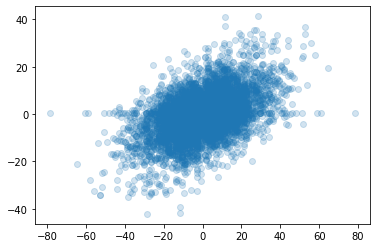

In [29]:
plt.scatter(targets, preds, alpha=0.2)
plt.show()

In [30]:
np.sqrt(mean_squared_error(targets, preds)), r2_score(targets, preds)

(13.383307, 0.203527816140199)

In [34]:
(np.sign(preds) == np.sign(targets)).mean()

0.6408250355618776